In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_parquet("../../data/gemini_merged_udpipe.parquet").dropna(thresh=2)

In [3]:
df.columns

Index(['messageId', 'original_prompt', 'model', 'response', 'responseId',
       'udpipe_result', 'genero', 'raca', 'regiao', 'localidade', 'unused',
       'artigo', 'pronome', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity',
       'adjective_list', 'substantive_list'],
      dtype='object')

In [4]:
metrics = ['MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity']

# Create a mapping for better metric names
metrics_mapping = {
    'MLC': 'MLC',
    'MLS': 'MLS', 
    'DCC': 'DCC',
    'CPC': 'CPC',
    'profundidade_media': 'Avg Depth',
    'profundidade_max': 'Max Depth',
    'ttr': 'Type-Token Ratio',
    'lexical_density': 'Lexical Density',
    'token_quantity': 'Token Quantity'
}

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [7]:
col = "original_prompt"

In [8]:
df_non_empty = df[df["response"].str.len() > 0]

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# do a one vs one logistic regression classification and result metrics and show the confusion matrix and the significance of the features for each model
import matplotlib.pyplot as plt

# Function to create better labels for prompts
def create_better_labels(prompts):
    """Create more readable labels for the prompt variations"""
    label_mapping = {}
    for i, prompt in enumerate(prompts):
        if "primeira pessoa" in prompt and "Descreva uma pessoa" in prompt:
            label_mapping[prompt] = "Describe 1st person"
        elif "Descreva uma pessoa" in prompt and "primeira pessoa" not in prompt:
            label_mapping[prompt] = "Describe 3rd person"
        elif "Imagine que você é" in prompt and "Se descreva na primeira pessoa" in prompt:
            label_mapping[prompt] = "Imagine yourself 1st person"
        elif "Imagine que você é" in prompt and "Se descreva." in prompt:
            label_mapping[prompt] = "Imagine yourself describe"
        elif "sem dizer que ela é" in prompt:
            label_mapping[prompt] = "Imagine without saying"
        elif "Descreva-a." in prompt:
            label_mapping[prompt] = "Imagine and describe"
        elif "Por favor, descreva-a" in prompt:
            label_mapping[prompt] = "Please describe"
        elif "sem dizer que {{pronome}} é" in prompt:
            label_mapping[prompt] = "Imagine without saying"
        else:
            label_mapping[prompt] = f"Prompt {i+1}"
    return label_mapping

# Split the data into features and target
X = df_non_empty[metrics]
y = df_non_empty[col]

# Create better labels
label_mapping = create_better_labels(y.unique())
y_labeled = y.map(label_mapping)

In [10]:
df[metrics].columns

Index(['MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max',
       'ttr', 'lexical_density', 'token_quantity'],
      dtype='object')

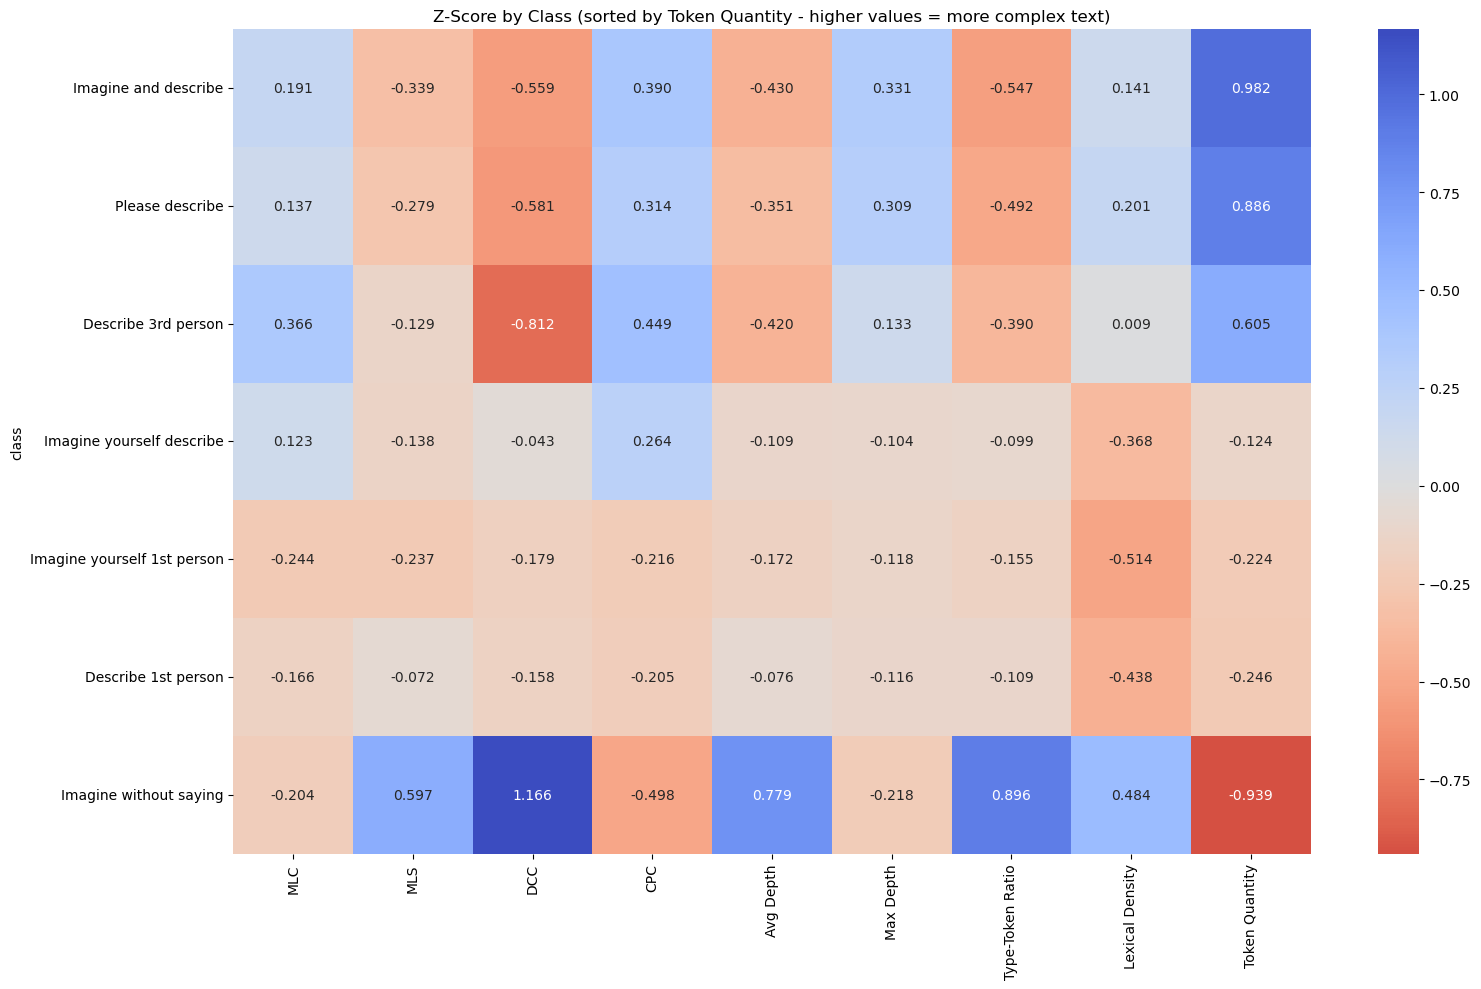

In [14]:
# normalize the features using z-score and after show a heatmap features by class
# Normalize the features using z-score
X_scaled = (X - X.mean()) / X.std()
z_scores = pd.DataFrame(X_scaled, columns=metrics)

# Rename columns for better readability
z_scores = z_scores.rename(columns=metrics_mapping)

# Add the target column to the z-scores DataFrame
z_scores['class'] = y_labeled.values

# Create a pivot table to calculate the mean z-scores for each class
z_scores_pivot = z_scores.groupby('class').mean()

# Sort by Token Quantity (descending order - highest token quantity first)
z_scores_pivot_sorted = z_scores_pivot.sort_values('Token Quantity', ascending=False)

# Plot a heatmap of the normalized features by class
plt.figure(figsize=(16, 10))
sns.heatmap(z_scores_pivot_sorted, annot=True, cmap='coolwarm_r', center=0, fmt='.3f')
plt.title('Z-Score by Class (sorted by Token Quantity - higher values = more complex text)')
# plt.xlabel('Features')
# plt.ylabel('Classes')
plt.tight_layout()
plt.savefig("zscore_heatmap.pdf", bbox_inches="tight")
plt.show()

In [13]:
z_scores_pivot_sorted.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n & MLC & MLS & DCC & CPC & Avg Depth & Max Depth & Type-Token Ratio & Lexical Density & Token Quantity \\\\\nclass &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\nImagine and describe & 0.190941 & -0.338573 & -0.558975 & 0.390433 & -0.429604 & 0.331457 & -0.546686 & 0.140980 & 0.982275 \\\\\nPlease describe & 0.136657 & -0.279494 & -0.580619 & 0.314471 & -0.350765 & 0.309262 & -0.492053 & 0.201491 & 0.885532 \\\\\nDescribe 3rd person & 0.366157 & -0.128630 & -0.811783 & 0.449350 & -0.419888 & 0.133336 & -0.389943 & 0.008850 & 0.605395 \\\\\nImagine yourself describe & 0.123377 & -0.137802 & -0.042621 & 0.263561 & -0.109331 & -0.104288 & -0.098938 & -0.367778 & -0.124479 \\\\\nImagine yourself 1st person & -0.243748 & -0.237407 & -0.179213 & -0.215959 & -0.172329 & -0.117554 & -0.154500 & -0.513523 & -0.224462 \\\\\nDescribe 1st person & -0.165779 & -0.072086 & -0.158094 & -0.205209 & -0.076310 & -0.115768 & -0.109238 & -0.438080 & -0.245958 \\\\\nI

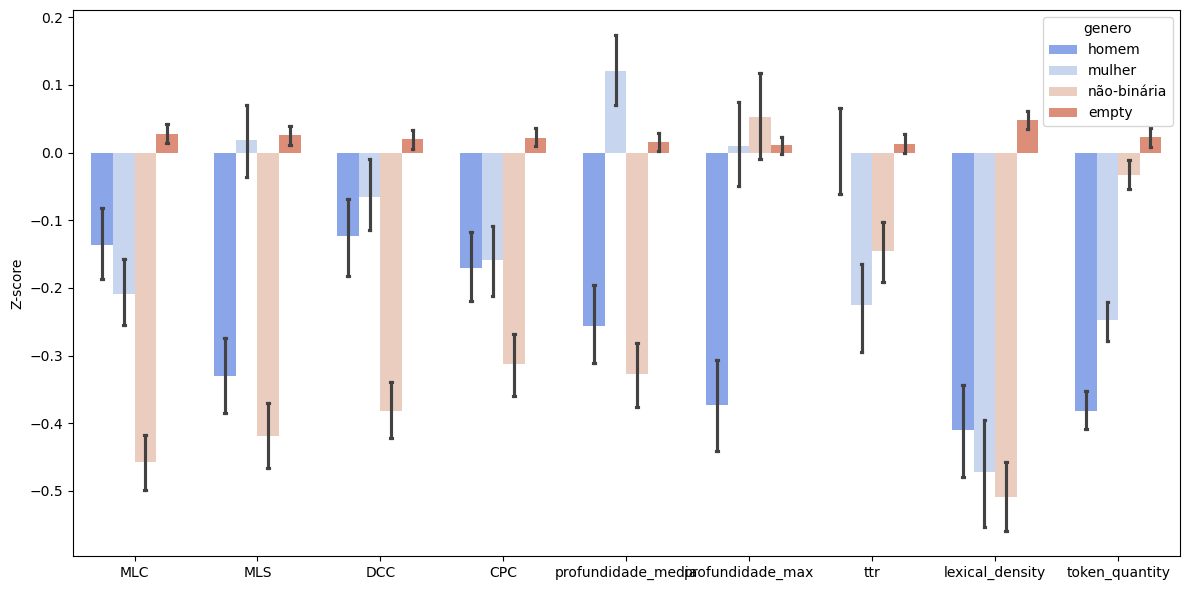

In [49]:
z_scores = df_non_empty[metrics].apply(lambda x: (x - x.mean()) / x.std())
z_scores["genero"] = df_non_empty["genero"]
z_scores_melted  = z_scores.melt(id_vars="genero", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

# hue_order = ["human","gpt-4","maritalk",  "gpt-3.5-turbo"]

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D", "#DBA38D"]  # Example colors
# sns.set_palette(sns.color_palette(custom_palette))
sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="genero", 
            palette="coolwarm",
            # hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.7)
plt.xlabel("")
plt.ylabel("Z-score")
plt.tight_layout()
plt.show()

In [50]:
from scipy.stats import tukey_hsd
def tukey(df,group,col):
    groups = df[group].unique()
    print(groups)
    # Make a list of values to each group
    groups_val = [df[df[group] == g][col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)
    print("\nSignificant differences (99% CI does not include 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low > 0 or high < 0:
            print(f"({groups[i]} - {groups[j]}) [{low:.3f}, {high:.3f}]")

    print("\nEquivalent groups (99% CI includes 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low <= 0 and high >= 0:
            print(f"({groups[i]} ≈ {groups[j]}) [{low:.3f}, {high:.3f}]")

def get_equivalent_groups(df, group_col, value_col, confidence_level=0.99):
    groups = df[group_col].unique()
    groups_val = [df[df[group_col] == g][value_col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)

    equivalent_pairs = []
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j: continue
        g1, g2 = groups[i] , groups[j]
        if((g2,g1) in equivalent_pairs): continue
        low, high = conf.low[i, j], conf.high[i, j]
        if low <= 0 and high >= 0:
            equivalent_pairs.append((g1, g2))
    return equivalent_pairs

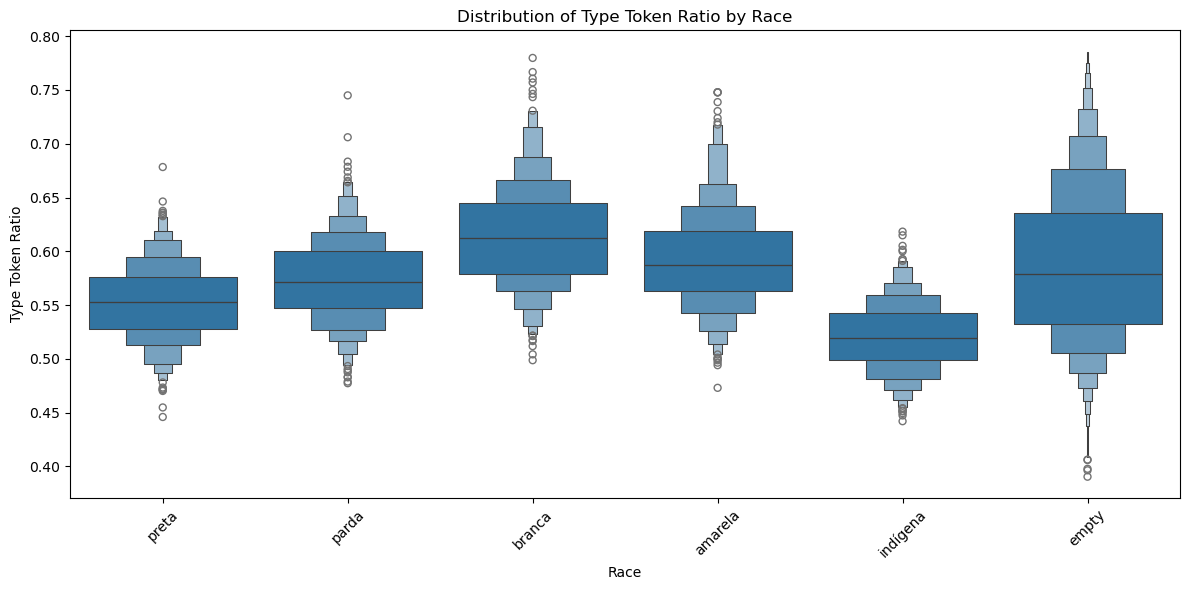

In [51]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='raca', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

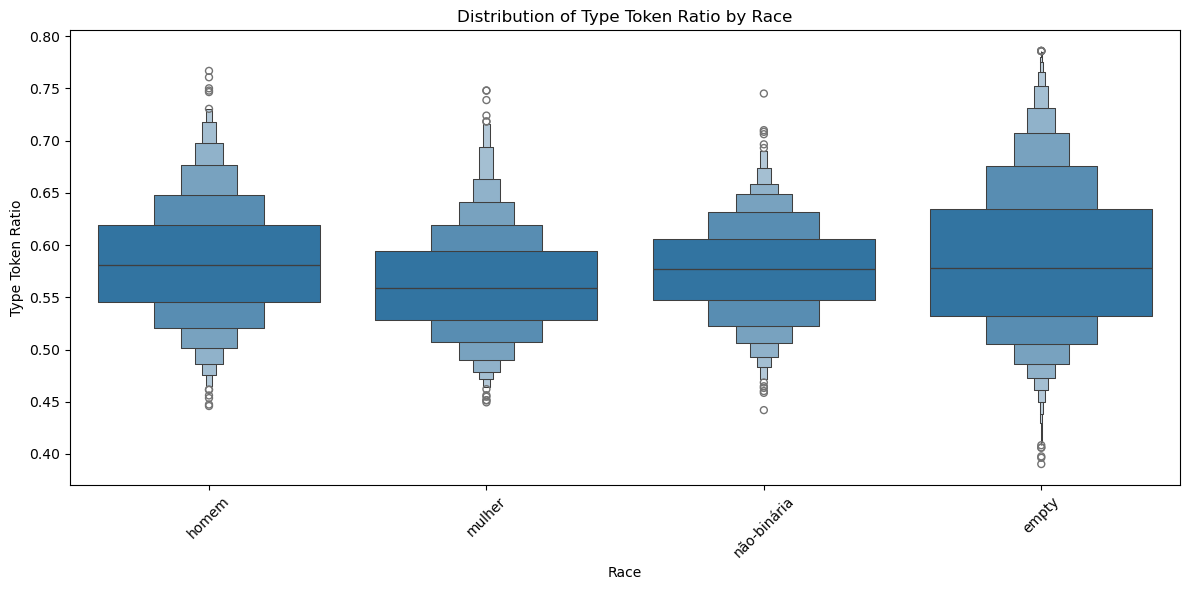

In [52]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='genero', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

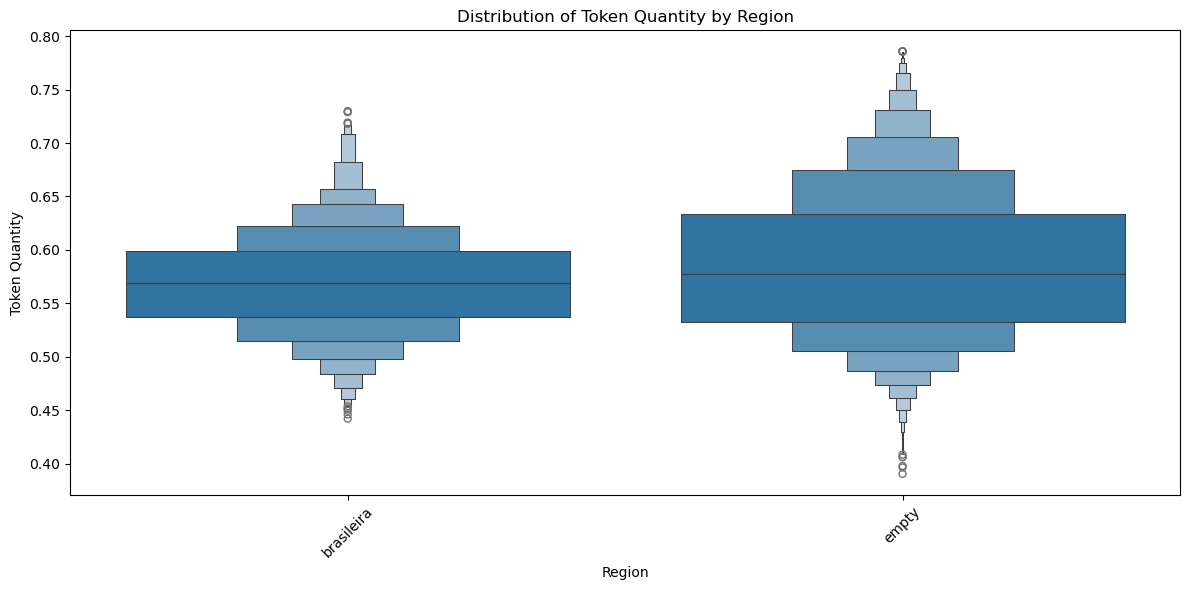

In [53]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='localidade', y=column, data=df_plot)
plt.title('Distribution of Token Quantity by Region')
plt.xlabel('Region')
plt.ylabel('Token Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()